In [3]:
# ============================================================
# 🩹 WOUND MODULE — CNN + GRAD-CAM + RAG + GEMINI ADAPTIVE Q&A
# Improved and Fully Working Version (Refined from Skin Module)
# ============================================================

# =========================================
# STEP 1: Install & Import
# =========================================
!pip install tensorflow pillow google-generativeai faiss-cpu sentence-transformers --quiet

import os, re, json, cv2, faiss
import numpy as np
import matplotlib.pyplot as plt
from difflib import get_close_matches
from PIL import Image
from google.colab import files, userdata
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing.image import img_to_array
import google.generativeai as genai
from sentence_transformers import SentenceTransformer

# =========================================
# STEP 2: Upload & Load Model
# =========================================
print("📤 Upload your trained wound model (.h5 file):")
uploaded_model = files.upload()
model_file = list(uploaded_model.keys())[0]
model = load_model(model_file)
print(f"✅ Model '{model_file}' loaded successfully!")




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 62.7 MB/s eta 0:00:00
📤 Upload your trained wound model (.h5 file):


Saving wound_classification_model.h5 to wound_classification_model.h5


✅ Model 'wound_classification_model.h5' loaded successfully!


🧠 Model expects input size: (150, 150)

📷 Upload a wound image for diagnosis:


Saving 7_0.jpg to 7_0.jpg
✅ Image preprocessed to match model input shape (150, 150)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

🔍 Top-3 Predictions:
   Diabetic Wounds: 75.65%
   Surgical Wounds: 12.37%
   Pressure Wounds: 10.85%


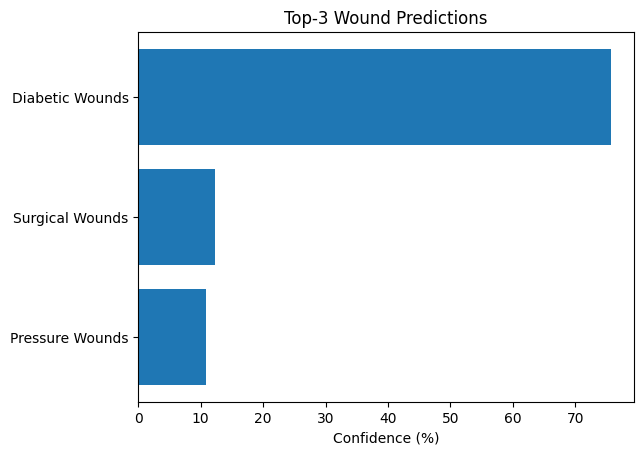


🎯 Generating enhanced visual explanation...


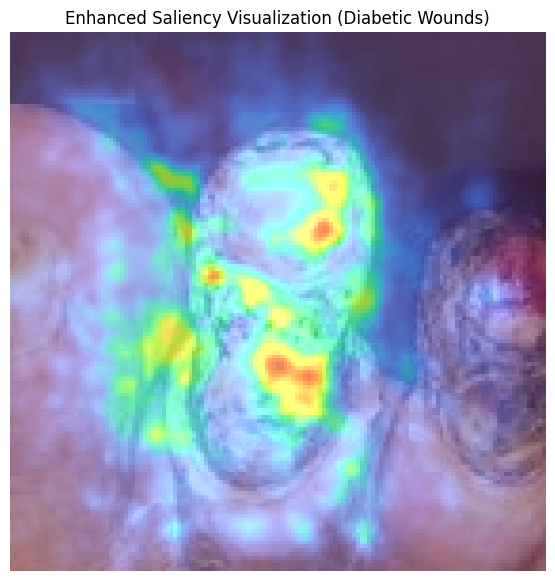

✅ Enhanced visualization saved as 'visual_explanation.png'

📚 Upload 'wounds.txt' knowledge base:


Saving wound_s.txt to wound_s (1).txt
✅ Indexed 10 wound topics

🧾 RAG Knowledge Extract:
 ### Diabetic Wounds
Diabetic Wounds (Foot Ulcers)
Overview:
Chronic wounds in diabetic patients due to neuropathy, ischemia, and infection. Common on feet or pressure areas. High risk of amputation if untreated.
Causes and Risk Factors:
- Poor blood sugar control
- Loss of sensation (neuropathy)
- Poor circulation (ischemia)
- Inadequate foot care, ill-fitting shoes
Symptoms and Clinical Presentation:
- Open wound, often painless
- Foul odor, discharge, black necrotic tissue
- Delayed healing
- Swelling, redness, or fever (infection)
Diagnosis:
- Clinical examination, wound culture, and imaging (to rule out bone infection)
- Blood glucose and vascular assessment
Treatment and Medications:
- Debridement of dead tissue
- Antibiotics for infection
- Moist wound care dressings
- Pressure offloading (special shoes or casts)
- Blood sugar control
Home Care and Prevention:
- Daily foot inspection
- Avoi

In [13]:
# =========================================
# STEP 3: Define Classes
# =========================================
class_names = [
    'Abrasions', 'Bruises', 'Burns', 'Cut', 'Diabetic Wounds',
    'Laseration', 'Normal', 'Pressure Wounds', 'Surgical Wounds', 'Venous Wounds'
]

# =========================================
# STEP 4: Auto Image Preprocessing (Dynamic)
# =========================================
try:
    input_shape = model.input_shape[1:3]
    print(f"🧠 Model expects input size: {input_shape}")
except:
    input_shape = (150, 150)
    print("⚠️ Could not detect model input size — defaulting to (150, 150)")

def preprocess_image(img, target_size=input_shape):
    img = img.resize(target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img / 255.0

# =========================================
# STEP 5: Upload Image for Prediction
# =========================================
from google.colab import files # Import files here
print("\n📷 Upload a wound image for diagnosis:")
uploaded_image = files.upload()
image_file = list(uploaded_image.keys())[0]
image = Image.open(image_file)
image_array = preprocess_image(image, target_size=input_shape)
print(f"✅ Image preprocessed to match model input shape {input_shape}")

# =========================================
# STEP 6: CNN Prediction
# =========================================
prediction = model.predict(image_array)[0]
top3_idx = prediction.argsort()[-3:][::-1]
top3_classes = [class_names[i] for i in top3_idx]
top3_probs = [prediction[i] for i in top3_idx]

print("\n🔍 Top-3 Predictions:")
for cls, prob in zip(top3_classes, top3_probs):
    print(f"   {cls}: {prob*100:.2f}%")

# Optional visualization
plt.barh(top3_classes[::-1], [p*100 for p in top3_probs[::-1]])
plt.xlabel("Confidence (%)")
plt.title("Top-3 Wound Predictions")
plt.show()

# =========================================
# STEP 7: Enhanced Visual Explanation (Refined Heatmap)
# =========================================
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def visualize_saliency(model, img_array, class_idx=None, blur_sigma=1.5):
    """
    Enhanced gradient-based saliency with noise smoothing.
    """
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        if class_idx is None:
            class_idx = tf.argmax(preds[0])
        output = preds[:, class_idx]

    grads = tape.gradient(output, img_tensor)
    grads = tf.reduce_mean(tf.abs(grads), axis=-1)[0].numpy()

    # Gaussian blur to smooth noise
    grads = gaussian_filter(grads, sigma=blur_sigma)
    grads -= grads.min()
    grads /= (grads.max() + 1e-8)
    grads = cv2.resize(grads, (img_array.shape[2], img_array.shape[1]))
    return grads

def overlay_saliency(image_path, saliency_map, alpha=0.6, colormap=cv2.COLORMAP_TURBO):
    """
    Overlay with enhanced contrast and adaptive blending.
    """
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

    if image.shape[-1] == 4:  # RGBA
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Normalize saliency and create vibrant heatmap
    saliency_map = cv2.resize(saliency_map, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * saliency_map)
    heatmap = cv2.applyColorMap(heatmap, colormap)

    # Blend with dynamic intensity
    overlay = cv2.addWeighted(image, 1 - alpha, heatmap, alpha, 0)

    # Add contrast enhancement
    overlay = cv2.convertScaleAbs(overlay, alpha=1.2, beta=10)
    return overlay

try:
    print("\n🎯 Generating enhanced visual explanation...")
    class_idx = np.argmax(prediction)
    saliency_map = visualize_saliency(model, image_array, class_idx)
    overlay = overlay_saliency(image_file, saliency_map)

    plt.figure(figsize=(7,7))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Enhanced Saliency Visualization ({top3_classes[0]})")
    plt.show()

    # Save image
    output_path = "visual_explanation.png"
    cv2.imwrite(output_path, overlay)
    print(f"✅ Enhanced visualization saved as '{output_path}'")
except Exception as e:
    print("❌ Visualization failed:", str(e))

# =========================================
# STEP 8: RAG Integration
# =========================================
print("\n📚 Upload 'wounds.txt' knowledge base:")
# Import files here as well, as it's used again
from google.colab import files
uploaded = files.upload()
fname = list(uploaded.keys())[0]
with open(fname, 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Parse into sections
sections = re.split(r'\n(?=\d+\.\s)', raw_text.strip())
rag_data = {}
for s in sections:
    m = re.match(r'(\d+)\.\s*([A-Za-z\s’\'\-()]+)', s)
    if m:
        name = m.group(2).strip().lower()
        text = re.sub(r'^\d+\.\s*', '', s).strip()
        rag_data[name] = text
print(f"✅ Indexed {len(rag_data)} wound topics")

def normalize_name(n):
    match = get_close_matches(n.lower(), list(rag_data.keys()), n=1, cutoff=0.6)
    return match[0] if match else n.lower()

embed = SentenceTransformer('all-MiniLM-L6-v2')
keys = list(rag_data.keys())
emb = embed.encode([rag_data[k] for k in keys], show_progress_bar=False)
idx = faiss.IndexFlatL2(emb.shape[1])
idx.add(np.array(emb))

def retrieve(query, k=2):
    qv = embed.encode([query])
    D, I = idx.search(np.array(qv), k)
    return "\n\n".join([rag_data[keys[i]] for i in I[0]])

def clean_text(t):
    return "\n".join(l.strip() for l in t.split('\n') if l.strip())

rag_results = []
for w in top3_classes:
    wn = normalize_name(w)
    txt = clean_text(retrieve(f"{wn} wound care and overview"))
    rag_results.append(f"### {w}\n{txt}\n")

rag_summary = "\n\n".join(rag_results)
print("\n🧾 RAG Knowledge Extract:\n", rag_summary)

# =========================================
# STEP 9: Adaptive Gemini Q&A
# =========================================
try:
    GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY') or os.getenv("GOOGLE_API_KEY")
    genai.configure(api_key=GOOGLE_API_KEY)
    gem = genai.GenerativeModel("gemini-2.0-flash-lite")
    print("✅ Gemini API configured successfully.")
except Exception as e:
    print(f"❌ Failed to configure Gemini API: {e}")
    print("Add your API key to Colab Secrets as 'GOOGLE_API_KEY'.")
    raise



# --- Build a single prompt that requests 3–5 nurse questions with reasoning ---
prompt_cot1 = f"""
You are assisting a nurse to determine the exact wound type.
The CNN classifier's top-3 predicted classes are:
{top3_classes}

Wound-knowledge summary (from RAG):
{rag_summary[:1500]}

Task (Chain-of-Thought style):
1️⃣ Generate between 3 and 5 clarifying questions a nurse should ask or observe to identify the exact wound type.
2️⃣ For each question, include a short reasoning (1–2 sentences) explaining WHY this question is important and HOW it helps distinguish between the top-3 CNN predictions.
3️⃣ Focus on:
   - Physical examination details (size, depth, color, edges, discharge, infection)
   - Relevant patient history (diabetes, trauma, surgery, chronic pressure)
   - Observable wound features (location, tissue type, odor, exudate type)
4️⃣ Keep each question entry in this **exact format**:
Q1: <question> (Reason: <concise reasoning>)
Q2: ...
Q3: ...
5️⃣ Do not include any extra commentary, introductions, or conclusions.

"""

# --- Make the single generation call ---
response_cot1 = gem.generate_content(
    prompt_cot1,
    generation_config=genai.types.GenerationConfig(
        temperature=0.5,      # balanced for focused, factual, non-random output
        max_output_tokens=700
    )
)

questions_with_reasoning = response_cot1.text.strip()

# --- Print the result neatly ---
print("✅ CoT-style nurse questions (3–5):\n")
print(questions_with_reasoning)

nurse_answers = input("🩺 Nurse answer: ")

# =========================================
# STEP 10: Final Structured Medical Report (Advanced)
# =========================================

final_prompt = f"""
You are a medical AI assistant. A wound classification CNN model predicted the top 3 possible wound types:


 {top3_classes} ({[f'{p:.1%}' for p in top3_probs]})
- Grad-CAM lesion visualization focus areas
- RAG wound-knowledge summary: {rag_summary[:1500]}

The nurse has provided answers to clarifying questions:
{nurse_answers}

Using Chain-of-Thought reasoning, determine the most likely wound type.

Then, based on this final wound type only, provide:

1️⃣ Final prediction: The wound type with reasoning (why others are less likely).
2️⃣ First-aid guidance: Immediate care steps specific to this wound type for a rural nurse.
3️⃣ Dressing methods: Resource-friendly dressing techniques specific to this wound type.
4️⃣ Red-flag escalation signs: What requires urgent referral.

Ensure all instructions are practical for a rural nurse with limited resources.
"""





out = gem.generate_content(final_prompt)
print(out.text)

# Save report
with open("final_wound_report.txt", "w", encoding="utf-8") as f:
    f.write(out.text)
print("\n✅ Workflow complete — Advanced Wound-Care Report generated successfully!")